In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pickle

df = pd.read_csv("Clean_Data.csv")
df.sample(10)

TRAIN = True

## Predicting Readmission Within 30 days

In [2]:
X = df.drop(['readmitted','within30'],axis=1)
y = df['within30']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=5)
X_train.shape,X_test.shape

((46916, 123), (20107, 123))

In [3]:
y_train.value_counts()

0    44691
1     2225
Name: within30, dtype: int64

In [4]:
#import XGBoost classifier and accuracy
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

#instantiate model and train
if TRAIN:
    model1 = XGBClassifier(scale_pos_weight=20)
    model1.fit(X_train, y_train)
    pickle.dump(model1, open("model1.pickle.dat", "wb"))
else:
    model1 = pickle.load(open("model1.pickle.dat", "rb"))

# make predictions for test set
y_pred1 = model1.predict(X_test)

accuracy = accuracy_score(y_test, y_pred1)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 69.87%


In [5]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred1)

array([[13452,  5716],
       [  343,   596]])

In [6]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred1).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

True Negatives:  13452
False Positives:  5716
False Negatives:  343
True Positives:  596


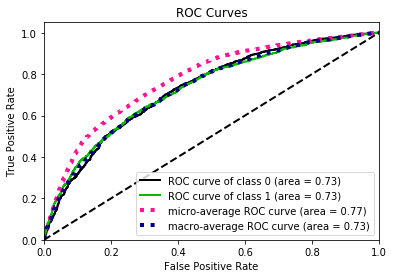

In [10]:
import scikitplot as skplt 
import matplotlib.pyplot as plt

y_pred_proba = model1.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_pred_proba)
plt.show()

Text(0.5,1,'2-class Precision-Recall curve: AP=0.08')

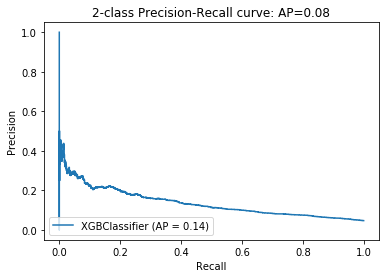

In [8]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score

average_precision = average_precision_score(y_test, y_pred1)
disp = plot_precision_recall_curve(model1, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

In [11]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 5) 
X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)
y_train_smote.value_counts()

1    44691
0    44691
Name: within30, dtype: int64

Trying SMOTE might help in the case of imbalanced datasets like fraud detection where the number of occurrences of fraud is extremely low compared to the data available. 

In [12]:
#instantiate model and train
if TRAIN:
    model2 = XGBClassifier()
    model2.fit(X_train, y_train)
    pickle.dump(model2, open("model2.pickle.dat", "wb"))
else:
    model2 = pickle.load(open("model2.pickle.dat", "rb"))

model2 = XGBClassifier()
model2.fit(X_train_smote, y_train_smote)

# make predictions for test set
y_pred2 = model2.predict(X_test)

accuracy = accuracy_score(y_test, y_pred2)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 94.67%


In [13]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred2)

array([[19017,   151],
       [  920,    19]])

In [14]:
tn2, fp2, fn2, tp2 = confusion_matrix(y_test, y_pred2).ravel()
print("True Negatives: ",tn2)
print("False Positives: ",fp2)
print("False Negatives: ",fn2)
print("True Positives: ",tp2)

True Negatives:  19017
False Positives:  151
False Negatives:  920
True Positives:  19


Not preferred as the main aim here is to detect true positives and the confusion matrix obtained is really bad! It seems like we would get better performance by trying to use XGBoost parameters for dealing with class imbalance.

## Predicting Readmission (No time period) -- More like risk/condition

In [15]:
y = df['readmitted']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=5)
X_train.shape,X_test.shape

((46916, 123), (20107, 123))

In [16]:
y_train.value_counts()

0    35153
1    11763
Name: readmitted, dtype: int64

In [17]:
#instantiate model and train
if TRAIN:
    model3 = XGBClassifier(scale_pos_weight=3)
    model3.fit(X_train, y_train)
    pickle.dump(model3, open("model3.pickle.dat", "wb"))
else:
    model3 = pickle.load(open("model3.pickle.dat", "rb"))

model3 = XGBClassifier(scale_pos_weight=3)
model3.fit(X_train, y_train)

# make predictions for test set
y_pred3 = model3.predict(X_test)

accuracy = accuracy_score(y_test, y_pred3)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 66.65%


In [18]:
confusion_matrix(y_test, y_pred3)

array([[10308,  4797],
       [ 1909,  3093]])

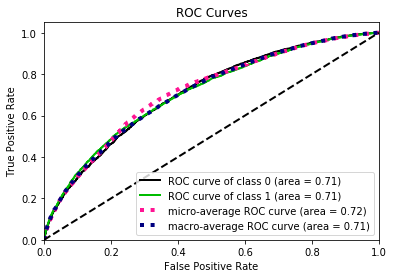

In [19]:
y_pred_proba = model3.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_pred_proba)
plt.show()

## Model Explainability

In [21]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model1, random_state=5).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

//anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Weight,Feature
0.0810 ± 0.0049,number_inpatient
0.0530 ± 0.0017,occurences
0.0080 ± 0.0022,admission_type_id_6
0.0059 ± 0.0009,admission_type_id_5
0.0035 ± 0.0002,discharge_disposition_id_25
0.0021 ± 0.0013,number_outpatient
0.0019 ± 0.0007,discharge_disposition_id_13
0.0017 ± 0.0007,discharge_disposition_id_18
0.0010 ± 0.0015,diabetesMed
0.0008 ± 0.0019,num_lab_procedures


In [ ]:
from pdpbox import pdp, get_dataset, info_plots

feature_names = X_test.columns.tolist()
pdp_goals = pdp.pdp_isolate(model=model1, dataset=X_test, model_features=feature_names, feature='number_inpatient')
pdp.pdp_plot(pdp_goals, 'Inpatient Number')
plt.show()

In [ ]:
import shap
explainer = shap.TreeExplainer(model1)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [ ]:
shap.dependence_plot('num_medications', shap_values, X_test)

Interesting! It is possible that too many medications and procedures have either cured the patient or caused death!

On further digging, we came to know that discharge_disposition_id 11 is expired, 13 and 14 mean hospice. Hence, these patients wouldn't be readmitted. This leads to better feature engineering where we can exclude patients who died or at hospice from our data.

### Explainability for individual patients

In [ ]:
test_row = X_test.iloc[10]
shap_values = explainer.shap_values(test_row)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, test_row)